In [1]:
try:
    import tqdm
except ModuleNotFoundError:
    !pip install tqdm
    import tqdm
try:
    import torchvision
except ModuleNotFoundError:
    !pip install torchvision
    import torchvision
try:
    import pypinyin
except ModuleNotFoundError:
    !pip install pypinyin
    import pypinyin

In [2]:
import torch
import PIL
from PIL import Image
import os
from torch import nn 
import numpy as np 
import random
from torch.utils import data
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm
from pypinyin import load_phrases_dict, Style, load_single_dict, lazy_pinyin
import heapq
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import random

In [3]:
# 参数dict
Config = {
    'n2w_save_path':'n2w.npy',
    'w2n_save_path':'w2n.npy',
    'pic_label_path':'key-indices.npy',
    'embedding_dim':200,
    'hidden_dim':1024,
    'batch_size':64,
    'lr':0.0008,
    'num_LSTM_layers':4,
    'num_epochs':30
}

In [4]:
# 字典路径
n2w = np.load(Config['n2w_save_path'], allow_pickle = True).item()
w2n = np.load(Config['w2n_save_path'], allow_pickle = True).item()
dictionary = np.load(Config['pic_label_path'], allow_pickle = True).item()
#
device = 'cpu'

In [5]:
class PoemModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(PoemModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim) 
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, 
                    num_layers=Config['num_LSTM_layers'], batch_first=True) # 根据数据集返回的sample，需要batch_first
        self.fc1 = nn.Linear(self.hidden_dim, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 4096)
        self.fc4 = nn.Linear(4096, vocab_size) # 输出维度与vocab大小相同

    def forward(self, input, hidden=None):
        # batch，seqlen
        embedding = self.embeddings(input)  
        # batch, seqlen, embedding_dim
        batch_size, seq_len = input.size()

        # 根据输入的hidden选择是否进行初始化
        if hidden is None:
            h_0 = torch.zeros((Config['num_LSTM_layers'], batch_size, self.hidden_dim),dtype=torch.float).to(input.device)
            c_0 = torch.zeros((Config['num_LSTM_layers'], batch_size, self.hidden_dim),dtype=torch.float).to(input.device)
        else: # 用于古诗生成
            h_0, c_0 = hidden

        # 前向
        output, hidden = self.lstm(embedding, (h_0, c_0))
        output = torch.tanh(self.fc1(output))
        output = torch.tanh(self.fc2(output))
        output = torch.tanh(self.fc3(output))
        output = self.fc4(output)

        # 平整为batch_size * seq_len， vocab_size       
        output = output.reshape(batch_size * seq_len, -1) 

        return output, hidden

In [6]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        # 经过处理后的x要与x的维度相同(尺寸和深度)
        # 如果不相同，需要添加卷积+BN来变换为同一维度
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# 用于ResNet50,101和152的残差块，用的是1x1+3x3+1x1的卷积
class Bottleneck(nn.Module):
    # 前面1x1和3x3卷积的filter个数相等，最后1x1卷积是其expansion倍
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=91):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*8, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, test = False):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = torch.squeeze(out) 
        out = out.view(out.size(0), -1)
        if test:
            out = out.view(-1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])



In [7]:
model = torch.load('./model85_complete.pth',map_location=torch.device('cpu'))

In [8]:
# 押韵
def choose_correct_word(pre_word, possible_list):
    
    tone = lazy_pinyin(pre_word, style=Style.FINALS)
    #print('tone is '+str(tone))
    wordsd = lazy_pinyin(pre_word, style=Style.TONE3)
    wordsd = wordsd[0][-1]
    #print('wsd is '+ wordsd)
    tonelist = lazy_pinyin(possible_list, style=Style.FINALS)
    finalist = []
    #保证押韵
    for i in range(len(tonelist)):
        if tone[0] == tonelist[i]:
            finalist.append(possible_list[i])
    #保证平仄
    shengdiao = lazy_pinyin(finalist, style=Style.TONE3)
    #print(shengdiao)
    for i in range(len(shengdiao)):
        if int(wordsd) <= 2:
            if int(shengdiao[i][-1]) > 2:
                #保证声母不同
                if lazy_pinyin(pre_word, style=Style.INITIALS) != lazy_pinyin(finalist[i], style=Style.INITIALS):
                    return finalist[i]
        elif int(wordsd) > 2:
            if int(shengdiao[i][-1]) <= 2:
                if lazy_pinyin(pre_word, style=Style.INITIALS) != lazy_pinyin(finalist[i], style=Style.INITIALS):
                    return finalist[i]                    

In [9]:
# 生成诗句
def write(model, input_seq, n2w, w2n, device):

  sentence = input_seq
  
  # 加上起始符
  input_seq = '<' + input_seq
  # 获取起始部分长度
  input_seq_len = len(input_seq)
  # 转换为list
  input_seq = list(input_seq)

  # 初始状态
  hidden = torch.zeros((2, Config['num_LSTM_layers'], 1, Config['hidden_dim']), dtype=torch.float)

  # device相关
  model = model.to(device)
  hidden = hidden.to(device)

  model.eval()
  with torch.no_grad():
    for i in range(input_seq_len):
      # 在句首使用teacher forcing，获取隐藏状态
      input = torch.Tensor([w2n[input_seq[i]]]).view(1, -1).long().to(device)
      # 送入模型
      output, hidden = model(input, hidden)

    for i in range(12):
      # 押韵
      if len(sentence) == 10:     
        # 获取topk
        topk = output.data[0].topk(1000)[1].detach().to('cpu').numpy().tolist()
        topk = [n2w[x] for x in topk]
        sentence += choose_correct_word(sentence[4], topk)
        sentence += '。'
        break

      if len(sentence) == 5:
        # 获取top1
        top_indice = output.data[0].topk(1)[1][0].item()
      else:
        # 获取top3
        top_indice = output.data[0].topk(3)[1][random.randint(0, 2)].item()

      # 根据上一步的输出获取下一步的输入
      input = torch.Tensor([top_indice]).view(1, -1).long().to(device)
      # 加入句子中
      sentence += n2w[top_indice]
      # 迭代
      output, hidden = model(input, hidden)
    
    # sentence = sentence[:-2]
      
    return sentence # 去掉结束符号

In [10]:
# 生成诗句
def write_without_rhyme(model, input_seq, n2w, w2n, device):

  sentence = input_seq
  
  # 加上起始符
  input_seq = '<' + input_seq
  # 获取起始部分长度
  input_seq_len = len(input_seq)
  # 转换为list
  input_seq = list(input_seq)

  # 初始状态
  hidden = torch.zeros((2, Config['num_LSTM_layers'], 1, Config['hidden_dim']), dtype=torch.float)

  # device相关
  model = model.to(device)
  hidden = hidden.to(device)

  model.eval()
  with torch.no_grad():
    for i in range(input_seq_len):
      # 在句首使用teacher forcing，获取隐藏状态
      input = torch.Tensor([w2n[input_seq[i]]]).view(1, -1).long().to(device)
      # 送入模型
      output, hidden = model(input, hidden)

    for i in range(10):

      if len(sentence) == 5:
        # 获取top1
        top_indice = output.data[0].topk(1)[1][0].item()
      else:
        # 获取top3
        top_indice = output.data[0].topk(3)[1][random.randint(0, 2)].item()

      # 根据上一步的输出获取下一步的输入
      input = torch.Tensor([top_indice]).view(1, -1).long().to(device)
      # 加入句子中
      sentence += n2w[top_indice]
      # 迭代
      output, hidden = model(input, hidden)
      
    return sentence + '。' 

In [11]:
VisModel=torch.load('ResNet34.pt',map_location=torch.device('cpu'))

In [12]:
def pic2poem(path, top = 5):
    images = os.listdir(path)
    for img in images:
        try:
            image = PIL.Image.open(path + '/' + img)
            image = image.resize((128,64),PIL.Image.ANTIALIAS)
            plt.imshow(image)
            plt.show()
            if image.size[0]!=3:
                image = image.convert("RGB")
            ten = transforms.ToTensor()
            image = ten(image)
            image.permute(0,2,1)
            image = image.unsqueeze(0)
            out = VisModel(image.to(device),test=True).to('cpu').detach().numpy()
            idx = heapq.nlargest(top, range(len(out)), out.__getitem__)
            pred = []
            for index in idx:
                ans = list(dictionary.keys())[list(dictionary.values()).index(index)]
                pred.append(ans)
            poem = []
            poem.append(write(model, pred[0], n2w, w2n, device))
            poem.append(write_without_rhyme(model, pred[random.randint(1, top - 1)], n2w, w2n, device))
            print(poem[0])
            print(poem[1])
        except:
            pass
        

In [13]:
def rhyme(path, top = 5):
    images = os.listdir(path)
    for img in images:
        try:
            image = PIL.Image.open(path + '/' + img)
            image = image.resize((128,64),PIL.Image.ANTIALIAS)
            plt.imshow(image)
            plt.show()
            if image.size[0]!=3:
                image = image.convert("RGB")
            ten = transforms.ToTensor()
            image = ten(image)
            image.permute(0,2,1)
            image = image.unsqueeze(0)
            out = VisModel(image.to(device),test=True).to('cpu').detach().numpy()
            idx = heapq.nlargest(top, range(len(out)), out.__getitem__)
            pred = []
            for index in idx:
                ans = list(dictionary.keys())[list(dictionary.values()).index(index)]
                pred.append(ans)
            poem = []
            poem.append(write(model, pred[0], n2w, w2n, device))
            poem.append(write(model, pred[1], n2w, w2n, device))
            poem.append(write_without_rhyme(model, pred[0], n2w, w2n, device))
            poem.append(write_without_rhyme(model, pred[1], n2w, w2n, device))
            print(poem[0])
            print(poem[1])
            print(poem[2])
            print(poem[3])
        except:
            pass

In [14]:
def show(path, model = VisModel, top = 5):
    images = os.listdir(path)
    
    for img in images:
        try:
            image = PIL.Image.open(path + '/' + img)
            image = image.resize((128,64),PIL.Image.ANTIALIAS)
            plt.imshow(image)
            plt.show()
            if image.size[0]!=3:
                image = image.convert("RGB")
            ten = transforms.ToTensor()
            image = ten(image)
            image.permute(0,2,1)
            image = image.unsqueeze(0)
            out = model(image.to(device),test=True).to('cpu').detach().numpy()
            idx = heapq.nlargest(top, range(len(out)), out.__getitem__)
            pred = []
            for index in idx:
                ans = list(dictionary.keys())[list(dictionary.values()).index(index)]
                pred.append(ans)
            print(pred)
        except:
                pass

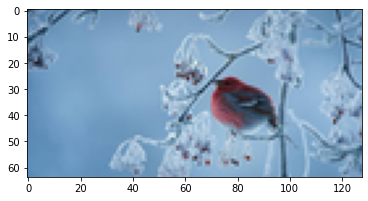

船去鸥鸣骑，花过岛屿齿。
雪暗非处喻，天深不肯嘘。
船中江棹旅，水阔阻烟霞。
雪中临地冻，钟隐出云香。


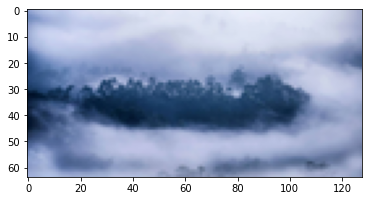

山水思可事，市迎思独集。
雨后秋更好，蟾光淡更饶。
山水分乡院，岑埃属北原。
雨后秋霜冷，风中夜露偏。


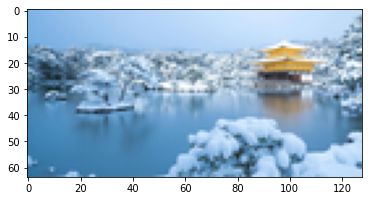

船去头落镜，朝沈雷似苹。
雨雪如锺燕，新茔出宝鞭。
船行不向陇，雁度始同登。
雨雪随僧拄，星鞍向国悬。


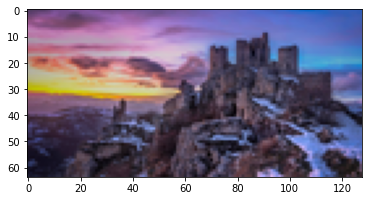

山水自氤寞，徇尊不可博。
兵戈随去屐，康彦劳藏翼。
山水分乡县，棊书却姓高。
兵火有名女，廻频诸客心。


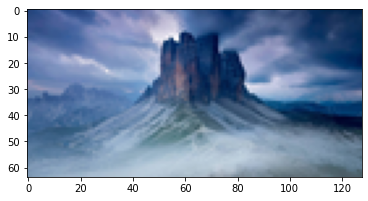

船中无斧柄，地美有时星。
海上归犹在，桑边钓已开。
船行上浦入，夫壻驰心偏。
海云迎宿濑，江月伴秋棊。


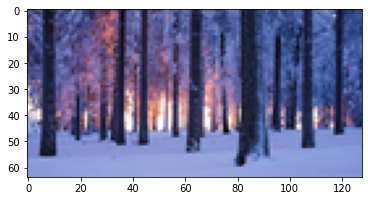

雪中凌晨警，蛾过任风屏。
帆影泛空塘，蝉声催乱岗。
雪暗多残磬，松高半废猨。
帆下不得时，泻水能得价。


In [15]:
rhyme('test')

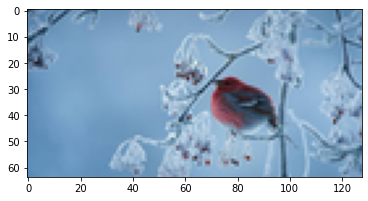

船行不数蹄，旭日满明笥。
霜露肃心土，边田壮谣标。


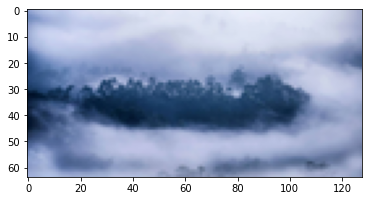

山川临洞土，亭水入申书。
兵戈随出众，道道祗从容。


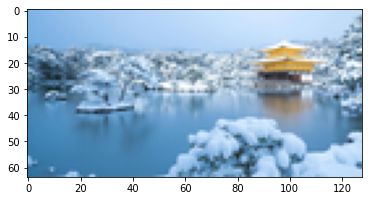

船去乌罗动，人同桂石通。
水色冰味浅，荷响势迷浅。


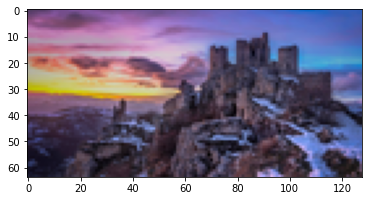

山水自可适，江山亦扃澌。
兵火烧文袜，阳仙挂玉绳。


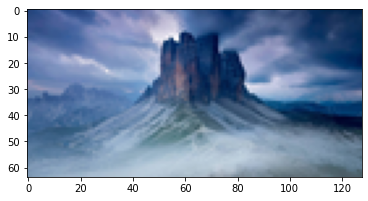

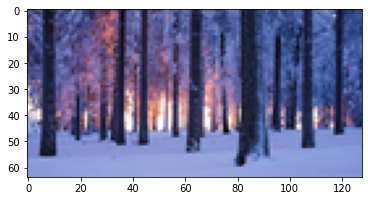

雪中凌晨雨，花遍暗虚虚。
花开不共送，春月半相亲。


In [16]:
pic2poem('test')

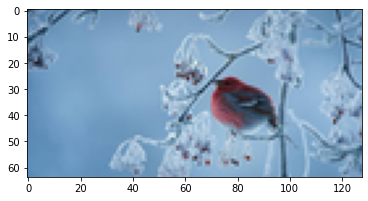

['船', '雪', '霜', '雨', '水']


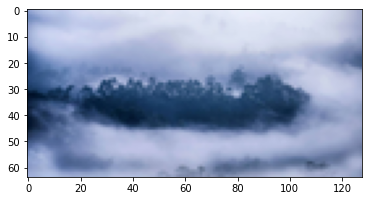

['山', '雨', '雪', '石', '兵']


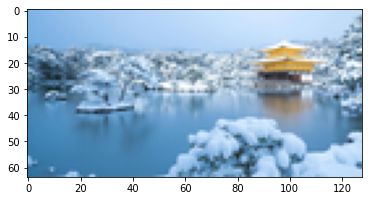

['船', '雨', '雪', '水', '柳']


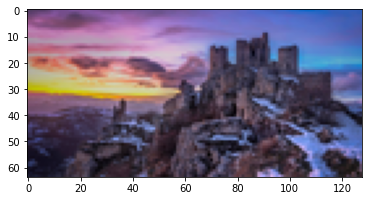

['山', '兵', '花', '路', '雨']


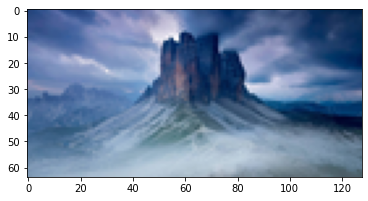

['船', '海', '雨', '霜', '雪']


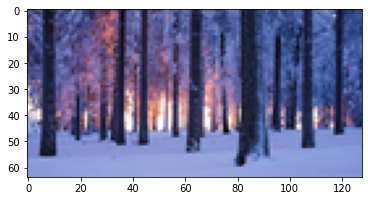

['雪', '帆', '雨', '花', '星']


In [17]:
show('test')